In [1]:
import torch
import importlib
import callback, my_attn
importlib.reload(callback)
importlib.reload(my_attn)
from diffusers import StableDiffusionPipeline, DDIMInverseScheduler, DDIMScheduler
from my_attn import prep_unet_attention
from tqdm.notebook import tqdm
from callback import QKVRecordCallback
from utils import load_image, img_to_latents, concat_img 

2024-06-03 07:00:40.277603: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-03 07:00:40.317700: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-03 07:00:40.317770: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-03 07:00:40.318821: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-03 07:00:40.325501: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-03 07:00:40.326123: I tensorflow/core/platform/cpu_feature_guard.cc:1

Same code with `callback.py`. Do not run this.

In [2]:
from dataclasses import dataclass
from diffusers import UNet2DConditionModel
import torch
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from utils import concat_img
from typing import Optional, List, Tuple, Dict


ATTN_BLOCKS = [
    'down_blocks.0.attentions.0.transformer_blocks.0.attn1',
    'down_blocks.0.attentions.0.transformer_blocks.0.attn2',
    'down_blocks.0.attentions.1.transformer_blocks.0.attn1',
    'down_blocks.0.attentions.1.transformer_blocks.0.attn2',
    'down_blocks.1.attentions.0.transformer_blocks.0.attn1',
    'down_blocks.1.attentions.0.transformer_blocks.0.attn2',
    'down_blocks.1.attentions.1.transformer_blocks.0.attn1',
    'down_blocks.1.attentions.1.transformer_blocks.0.attn2',
    'down_blocks.2.attentions.0.transformer_blocks.0.attn1',
    'down_blocks.2.attentions.0.transformer_blocks.0.attn2',
    'down_blocks.2.attentions.1.transformer_blocks.0.attn1',
    'down_blocks.2.attentions.1.transformer_blocks.0.attn2',
    'up_blocks.1.attentions.0.transformer_blocks.0.attn1',
    'up_blocks.1.attentions.0.transformer_blocks.0.attn2',
    'up_blocks.1.attentions.1.transformer_blocks.0.attn1',
    'up_blocks.1.attentions.1.transformer_blocks.0.attn2',
    'up_blocks.1.attentions.2.transformer_blocks.0.attn1',
    'up_blocks.1.attentions.2.transformer_blocks.0.attn2',
    'up_blocks.2.attentions.0.transformer_blocks.0.attn1',
    'up_blocks.2.attentions.0.transformer_blocks.0.attn2',
    'up_blocks.2.attentions.1.transformer_blocks.0.attn1',
    'up_blocks.2.attentions.1.transformer_blocks.0.attn2',
    'up_blocks.2.attentions.2.transformer_blocks.0.attn1',
    'up_blocks.2.attentions.2.transformer_blocks.0.attn2',
    'up_blocks.3.attentions.0.transformer_blocks.0.attn1',
    'up_blocks.3.attentions.0.transformer_blocks.0.attn2',
    'up_blocks.3.attentions.1.transformer_blocks.0.attn1',
    'up_blocks.3.attentions.1.transformer_blocks.0.attn2',
    'up_blocks.3.attentions.2.transformer_blocks.0.attn1',
    'up_blocks.3.attentions.2.transformer_blocks.0.attn2',
    'mid_block.attentions.0.transformer_blocks.0.attn1',
    'mid_block.attentions.0.transformer_blocks.0.attn2',
]


def pca(x: torch.Tensor, target_dim: int):  # x: (n, d)
    _x = x.float()
    mean = _x .mean(dim=0)
    _x = _x - _x.mean(dim=0)
    U, S, V = torch.svd(_x)
    V_reduced = V[:, :target_dim]
    projected_x = torch.mm(_x, V_reduced)
    return projected_x


@dataclass
class QKV:
    t: int
    name: str
    q: Optional[torch.Tensor]
    k: Optional[torch.Tensor]
    v: Optional[torch.Tensor]
    a: Optional[torch.Tensor]
    guidance: bool

    def __getitem__(self, key: str) -> torch.Tensor:
        if key in ['q', 'k', 'v', 'a']:
            return getattr(self, key)


class QKVRecordCallback:
    def __init__(
        self,
        p: StableDiffusionPipeline,
        attn_index: List[int],
        record_per_step: int,
        start: int,
        end: int,
        name: str,
        inverse: bool = False
    ):
        r"""
        Add this callback to the pipeline.__call__() to record the QKV of the attentions.
        
        Args:
            p (StableDiffusionPipeline): The pipeline.
            attn_index (List[int]): The indices of the attentions to record. The indices are defined in `ATTN_BLOCKS`.
            record_per_step (int): Record the QKV every `record_per_step` steps.
            start (int): Start recording at step `start`.
            end (int): Stop recording at step `end`.
            name (str): The name of the callback.
            inverse (bool): If it is a DDIM-inversion, set `inverse` to `True`.
        """
        self.attentions: Dict[Tuple[QKV]] = {}
        for attn_id in attn_index:
            self.attentions[ATTN_BLOCKS[attn_id]] = []
        self.last_rec = 10000
        self.record_per_step = record_per_step
        self.start = start
        self.end = end
        self.pipe = p
        self.name = name
        self.inverse = inverse
        self.timesteps = []

    def __call__(self, p: StableDiffusionPipeline, i: int, t, kwargs):
        if i % self.record_per_step == 0 and self.start <= t < self.end:
            unet: UNet2DConditionModel = p.unet
            modules = list(unet.named_modules())
            for name, module in modules:
                if name in self.attentions:
                    q, k, v, a = module.processor.record_QKV()
                    if 'attn1' in name:  # only record the attn_map for cross-attention, since self-attention is too large.
                        a = None
                    if self.inverse:
                        self.attentions[name].insert(
                            0, QKV(t, name, q, k, v, a, module.processor.guidance))
                    else:
                        self.attentions[name].append(
                            QKV(t, name, q, k, v, a, module.processor.guidance))
            if self.inverse:
                self.timesteps.insert(0, t)
            else:
                self.timesteps.append(t)
            self.last_rec = t
        return kwargs

    def qkv_visualization(self, attn_id: int, qkv: str, dim=3, chunk=1):
        r"""
        Visualize the QKV of the attentions by projecting them into a 3D (RGB) space.
        
        Args:
            attn_id (int): The index of the attention.
            qkv (str): The QKV to visualize. It can be 'q', 'k', 'v'.
            dim (int): The dimension of the projected space.
            chunk (int): The chunk of the QKV. If guidance_scale > 1, there will be two latents.
                The first chunk is the unconditional (negative prompt) latent, and the second chunk is the conditional latent.
        """
        img_list = []
        for attn in tqdm(self.attentions[ATTN_BLOCKS[attn_id]]):
            guidance = attn.guidance
            tgt = attn[qkv]  # (heads, h*w, c)
            h, n, c = tgt.shape
            if guidance:
                tgt = torch.chunk(tgt, 2, dim=0)[chunk]
            tgt = tgt.permute(1, 2, 0).reshape(n, -1)  # (h*w, c*heads)
            hxw = tgt.shape[-2]
            size = int(hxw ** 0.5)
            tgt = pca(tgt, dim)
            image = tgt.transpose(-1, -2).reshape(dim, size, size)  # (dim, h, w)
            image = (image - image.min()) / (image.max() - image.min())
            image = image.unsqueeze(0)
            img_list.append(image)
        plt.figure(figsize=(20, 10))
        plt.title(f'{self.name}: {qkv} of {ATTN_BLOCKS[attn_id]}')
        plt.imshow(concat_img(img_list))

    def attn_map_visualization(self, attn_id: int, pos: int, temperature, prompt: str = '', chunk=1):
        r"""
        Visualize the attention maps of the attentions.
        
        Args:
            attn_id (int): The index of the attention.
            pos (int): The position of the token in the prompt.
            temperature (float): The temperature of the attention map.
            prompt (str): The prompt.
            chunk (int): The chunk of the attention map. If guidance_scale > 1, there will be two latents.
                The first chunk is the unconditional (negative prompt) latent, and the second chunk is the conditional latent.
        """
        img_list = []
        tokens = self.pipe.tokenizer.tokenize(prompt)
        for attn in tqdm(self.attentions[ATTN_BLOCKS[attn_id]]):
            guidance = attn.guidance
            tgt = attn.a  # (heads, h*w, 77)
            if guidance:
                tgt = torch.chunk(tgt, 2, dim=0)[chunk]
            attention_weights = tgt[:, :, pos + 1]  # (heads, h*w)
            tgt = attention_weights.mean(dim=0, keepdim=True)  # (1, h*w)
            hxw = tgt.shape[-1]
            size = int(hxw ** 0.5)
            image = tgt.transpose(-1, -2).reshape(1, size, size)
            image = (image - image.min()) / (image.max() - image.min())
            image = image.unsqueeze(0)
            img_list.append(image)
        img_list.append(sum(img_list) / len(img_list))
        print(tokens)
        plt.figure(figsize=(20, 10))
        plt.title(
            f'{self.name}: Attention maps of {ATTN_BLOCKS[attn_id]} to token "{tokens[pos]}"')
        plt.imshow(concat_img(img_list))


In [2]:
device = 'cuda'
dtype = torch.float16

pipe = StableDiffusionPipeline.from_pretrained(
    '/home/tom/fshare/models/runwayml/stable-diffusion-v1-5',
    safety_checker=None,
    torch_dtype=dtype
)
pipe.to(device)
vae = pipe.vae

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


#### Inverse process

Inverse the image and record the 12th and 13th attn_block. Use `DDIMInverseScheduler`.

The list of attn_blocks is in `callback.py`.

```Python
ATTN_BLOCKS = [
    'down_blocks.0.attentions.0.transformer_blocks.0.attn1',
    'down_blocks.0.attentions.0.transformer_blocks.0.attn2',
    'down_blocks.0.attentions.1.transformer_blocks.0.attn1',
    'down_blocks.0.attentions.1.transformer_blocks.0.attn2',
    'down_blocks.1.attentions.0.transformer_blocks.0.attn1',
    'down_blocks.1.attentions.0.transformer_blocks.0.attn2',
    'down_blocks.1.attentions.1.transformer_blocks.0.attn1',
    'down_blocks.1.attentions.1.transformer_blocks.0.attn2',
    'down_blocks.2.attentions.0.transformer_blocks.0.attn1',
    'down_blocks.2.attentions.0.transformer_blocks.0.attn2',
    'down_blocks.2.attentions.1.transformer_blocks.0.attn1',
    'down_blocks.2.attentions.1.transformer_blocks.0.attn2',
    'up_blocks.1.attentions.0.transformer_blocks.0.attn1',
    'up_blocks.1.attentions.0.transformer_blocks.0.attn2',
    'up_blocks.1.attentions.1.transformer_blocks.0.attn1',
    'up_blocks.1.attentions.1.transformer_blocks.0.attn2',
    'up_blocks.1.attentions.2.transformer_blocks.0.attn1',
    'up_blocks.1.attentions.2.transformer_blocks.0.attn2',
    'up_blocks.2.attentions.0.transformer_blocks.0.attn1',
    'up_blocks.2.attentions.0.transformer_blocks.0.attn2',
    'up_blocks.2.attentions.1.transformer_blocks.0.attn1',
    'up_blocks.2.attentions.1.transformer_blocks.0.attn2',
    'up_blocks.2.attentions.2.transformer_blocks.0.attn1',
    'up_blocks.2.attentions.2.transformer_blocks.0.attn2',
    'up_blocks.3.attentions.0.transformer_blocks.0.attn1',
    'up_blocks.3.attentions.0.transformer_blocks.0.attn2',
    'up_blocks.3.attentions.1.transformer_blocks.0.attn1',
    'up_blocks.3.attentions.1.transformer_blocks.0.attn2',
    'up_blocks.3.attentions.2.transformer_blocks.0.attn1',
    'up_blocks.3.attentions.2.transformer_blocks.0.attn2',
    'mid_block.attentions.0.transformer_blocks.0.attn1',
    'mid_block.attentions.0.transformer_blocks.0.attn2',
]
```

In [4]:
num_inversion_steps = 999
prep_unet_attention(pipe.unet)
imgname = 'images/atri.jpg'
input_img = load_image(
    imgname,
    target_size=(512, 512)
).to(device=device, dtype=dtype)
prompt_inversion = "an anime girl with background"

with torch.no_grad():
    attn_record_index = [12, 13]
    inverse_callback = QKVRecordCallback(
        pipe,
        attn_index=[1, 2, 12, 13],
        record_per_step=25,
        start=0,
        end=1000,
        name='inverse',
    )
    pipe.scheduler = DDIMInverseScheduler.from_pretrained(
        '/home/tom/fshare/models/runwayml/stable-diffusion-v1-5', subfolder='scheduler')
    latents = img_to_latents(input_img, vae)  # VAE latent
    inv_latents, _ = pipe(
        prompt=prompt_inversion,
        guidance_scale=1,
        width=input_img.shape[-1],
        height=input_img.shape[-2],
        output_type='latent',
        return_dict=False,
        num_inference_steps=num_inversion_steps,
        latents=latents,
        callback_on_step_end=inverse_callback
    )

  0%|          | 0/999 [00:00<?, ?it/s]

#### Reconstruct Process

Use `DDIMScheduler`. Different prompts and guidance scales can be tried here.

In [4]:
num_generation_steps_1 = 100
num_generation_steps_2 = 100
prompt_1 = prompt_inversion
prompt_2 = prompt_inversion.replace('girl', 'boy')
with torch.no_grad():
    pipe.scheduler = DDIMScheduler.from_pretrained(
        '/home/tom/fshare/models/runwayml/stable-diffusion-v1-5', subfolder='scheduler')
    image1 = pipe(
        prompt=prompt_1,
        guidance_scale=2,
        num_inference_steps=num_generation_steps_1,
        latents=inv_latents,
        output_type='pt',
    ).images[0]
    image2 = pipe(
        prompt=prompt_2,
        guidance_scale=2,
        num_inference_steps=num_generation_steps_2,
        latents=inv_latents, 
        output_type='pt'
    ).images[0]
    original = input_img[0]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

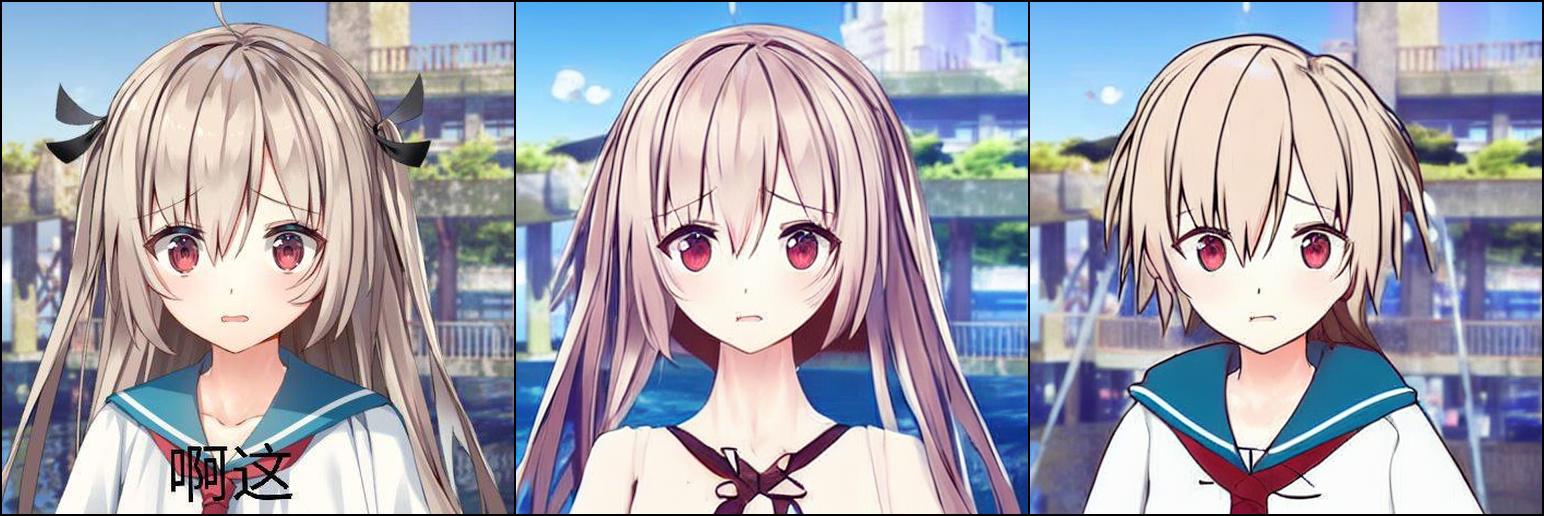

In [5]:
concat_img([original.unsqueeze(0), image1.unsqueeze(0), image2.unsqueeze(0)])

#### Attn Visualization for Inversion process

  0%|          | 0/40 [00:00<?, ?it/s]

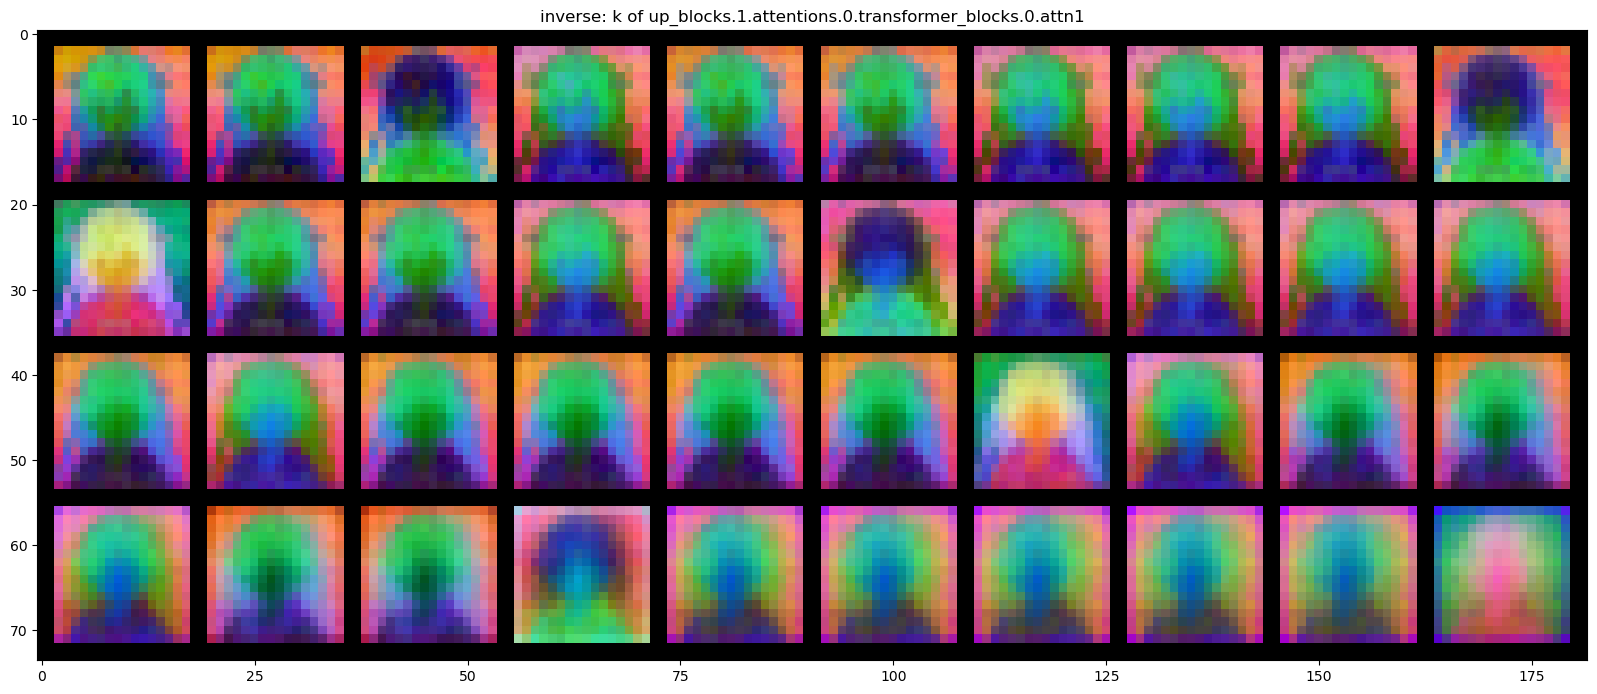

In [6]:
inverse_callback.qkv_visualization(12, 'k', 3)

  0%|          | 0/40 [00:00<?, ?it/s]

['an</w>', 'anime</w>', 'girl</w>', 'with</w>', 'background</w>']


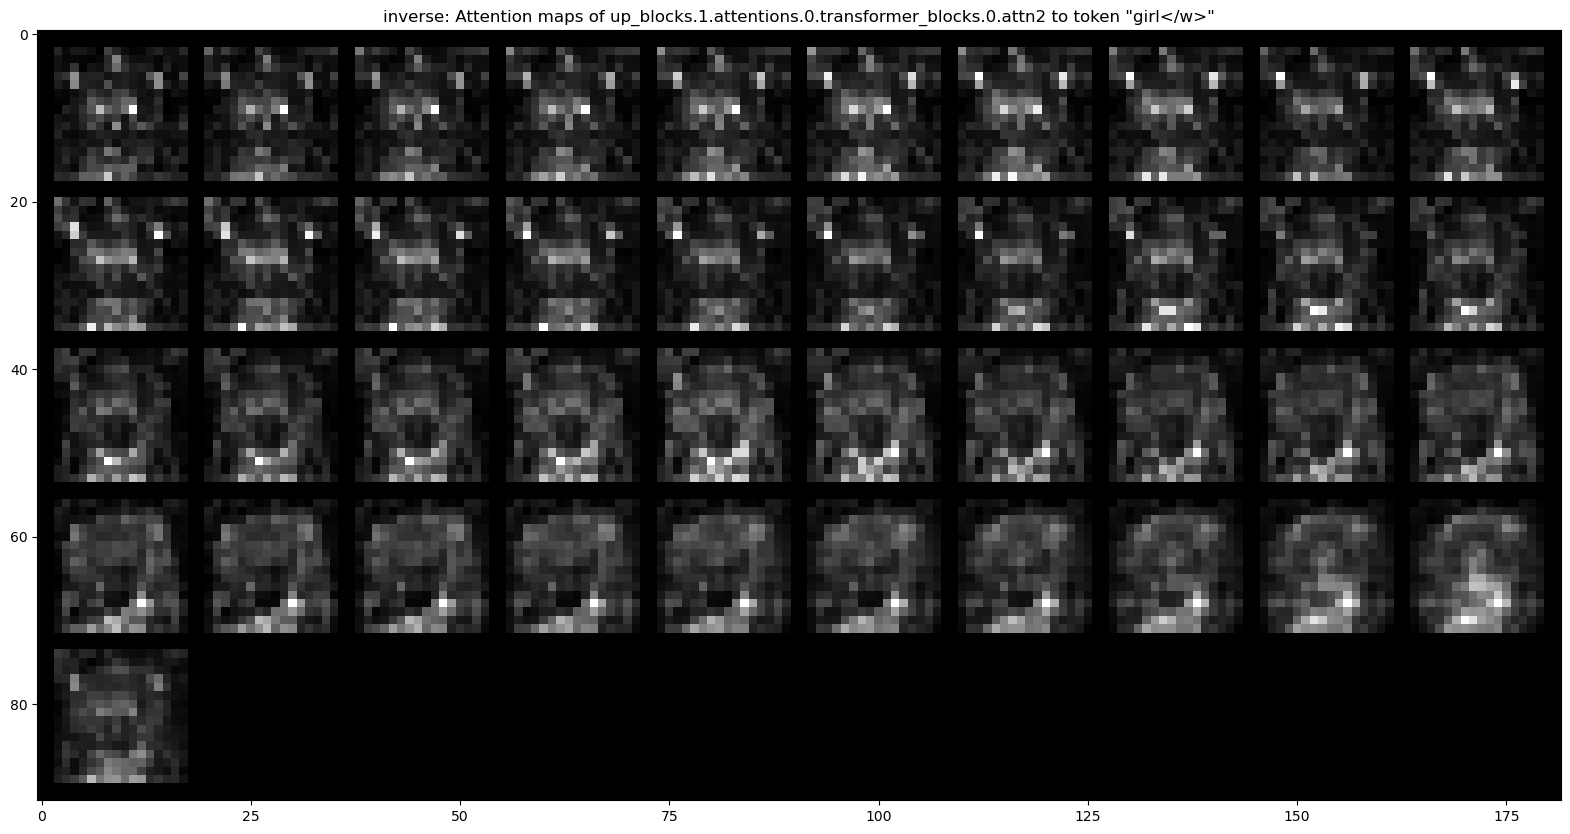

In [7]:
inverse_callback.attn_map_visualization(attn_id=13, pos=2, temperature=1, prompt=prompt_inversion, chunk=1)

In [ ]:
from callback import ATTN_BLOCKS
for _ in inverse_callback.attentions[ATTN_BLOCKS[12]]:
    print(_.t)

tensor(976, device='cuda:0')
tensor(951, device='cuda:0')
tensor(926, device='cuda:0')
tensor(901, device='cuda:0')
tensor(876, device='cuda:0')
tensor(851, device='cuda:0')
tensor(826, device='cuda:0')
tensor(801, device='cuda:0')
tensor(776, device='cuda:0')
tensor(751, device='cuda:0')
tensor(726, device='cuda:0')
tensor(701, device='cuda:0')
tensor(676, device='cuda:0')
tensor(651, device='cuda:0')
tensor(626, device='cuda:0')
tensor(601, device='cuda:0')
tensor(576, device='cuda:0')
tensor(551, device='cuda:0')
tensor(526, device='cuda:0')
tensor(501, device='cuda:0')
tensor(476, device='cuda:0')
tensor(451, device='cuda:0')
tensor(426, device='cuda:0')
tensor(401, device='cuda:0')
tensor(376, device='cuda:0')
tensor(351, device='cuda:0')
tensor(326, device='cuda:0')
tensor(301, device='cuda:0')
tensor(276, device='cuda:0')
tensor(251, device='cuda:0')
tensor(226, device='cuda:0')
tensor(201, device='cuda:0')
tensor(176, device='cuda:0')
tensor(151, device='cuda:0')
tensor(126, de

In [ ]:
def update_class_instances(instance, new_class):
    instance.__class__ = new_class

# update_class_instances(prompt1_callback, StableDiffusionCallback)
update_class_instances(inverse_callback, StableDiffusionCallback)